# PRML 1.1 例：多項式曲線フィッティング

---

## 概要

### 本節の目的

* 単純な回帰を例に、機械学習の重要な概念を説明する。

### アウトライン

* 機械学習の基本的な流れ
    1. 問題を決める
    2. データを集める
    3. モデルを選ぶ
    4. パラメータを調節する
* 機械学習の課題
    * データや問題に対してモデルが複雑すぎると過学習が起こる
    * モデルの複雑さを抑制し過学習を抑える必要がある
* 過学習の抑制方法
    * 訓練集合とテスト集合のそれぞれに対する誤差を求め過学習を評価する
    * モデルの複雑さを直接抑える
    * 正則化して複雑なモデルの実質的な複雑さを抑える

---

## 詳細

### 機械学習の基本的な流れ｜1. 問題を決める

ここでは、正弦波にノイズを乗せたデータに対する回帰問題を考える。<br>
回帰問題を解くことで次のような正弦波を得ることを目指す。

In [1]:
import numpy as np
from matplotlib import pyplot as plt

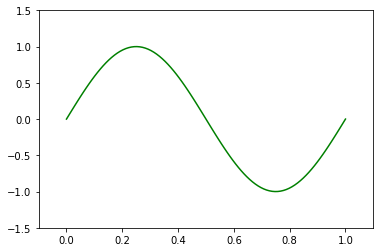

In [2]:
plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.show()

### 機械学習の基本的な流れ｜2. データを集める

$N$ 個の入力変数を並べたものを $\mathsf{\textbf{x}} = (x_1, \dots, x_N)^T$、目標変数を並べたものを $\mathsf{\textbf{t}} = (t_1, \dots, t_N)^T$ と表すことにする。

再現性を確保するためシードを固定する。

In [3]:
np.random.seed(seed = 0)

まず、訓練集合として $N = 10$ のときの $\mathsf{\textbf{x}}$ を作る。ここでは、$[0, 1]$ 区間内から等間隔に10個選ぶ。

In [4]:
N = 10
x = np.linspace(0, 1, N)
x

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

次に、$\mathsf{\textbf{x}} = (x_1, \dots, x_N)^T$ に対応する $\mathsf{\textbf{t}} = (t_1, \dots, t_N)^T$ を作る。<br>
正弦波にノイズを乗せたものを作りたいので、ここでは $\sin(2 \pi x)$ に標準偏差が0.3のガウス分布に従うランダムノイズを加える。

In [5]:
t = np.sin(2 * np.pi * x) + np.random.normal(scale = 0.3, size = N)
t

array([ 0.5292157 ,  0.76283477,  1.27842915,  1.53829336,  0.90228754,
       -0.63520351, -0.58099888, -1.03021492, -0.67375327,  0.12317955])

正弦波の上に $\mathsf{\textbf{x}}$ と $\mathsf{\textbf{t}}$ をプロットすると、次のようになる。

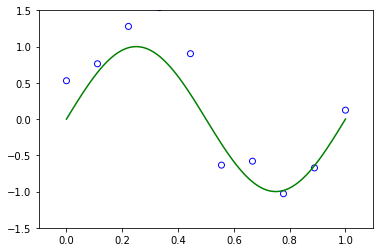

In [6]:
plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
plt.scatter(x, t, facecolors = 'none', edgecolors = "b")
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.show()

同様の手順で、テスト集合も作る。<br>
テスト集合の目的変数は本来未知だが、ここでは検証のために訓練集合と同様の手順で目的変数も作る。

In [7]:
N_test = 100
x_test = np.linspace(0, 1, N_test)
t_test = np.sin(2 * np.pi * x_test) + np.random.normal(scale = 0.3, size = N_test)

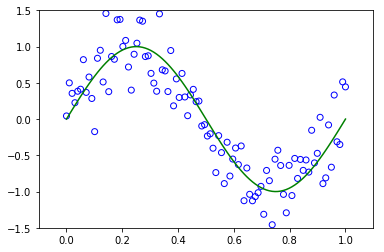

In [8]:
plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
plt.scatter(x_test, t_test, facecolors = 'none', edgecolors = "b")
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.show()

### 機械学習の基本的な流れ｜3. モデルを選ぶ

ここでは、モデルとして次の多項式を使う。<br>
$M$ は多項式の次数、$\textbf{w} = (w_0, w_1, \dots, w_M)^T$ は多項式の係数を表す。<br>
$\textbf{w}$ がこのモデルのパラメータである。

$$
y\left(x,\textbf{w}\right) = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M = \sum^{M}_{j = 0}{w_j x^j}
$$

このような、$\textbf{w}$ に対して線形なモデルを**線形モデル**と呼ぶ。<br>
線形モデルは重要な性質を持つ (詳細は3章と4章)。

### 機械学習の基本的な流れ｜4. パラメータを調節する

$\mathsf{\textbf{x}}$ と $\mathsf{\textbf{t}}$ を訓練集合として、モデルのパラメータを調節する。<br>
そのためには、モデルと訓練集合のずれを測る**誤差関数 (error function)** を定義し、その誤差関数を最小化するようなパラメータを求めればよい。<br>
広く使われている誤差関数として、二乗和誤差 (sum-of-squares error) がある。

$$
E \left(\textbf{w} \right) = \frac{1}{2} \sum^{N}_{n = 1}{\left \{y \left(x_n, \textbf{w} \right) - t_n \right\}}^2
$$

$E\left(\textbf{w} \right)$ は下に凸な2次関数であり、極値が最小値になるから、最小値を求めるためには $\frac{\partial}{\partial w_i} E\left(\textbf{w} \right) = 0$ を解けばよい。

(以下、演習1.1の解答) $E\left(\textbf{w}\right)$ を $w_i$ で偏微分すると、

$$
\begin{align}
\frac{\partial}{\partial w_i} E\left(\textbf{w}\right)
&= \frac{1}{2} \sum^{N}_{n = 1}{\left\{2 \left(\sum^{M}_{j = 0}{w_j \left(x_n \right)^j} - t_n \right) \left(x_n \right)^i \right\}} \\
&= \sum^{N}_{n = 1}{\left(\left(x_n \right)^i \sum^{M}_{j = 0}{w_j \left(x_n \right)^j} \right)} - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n} \\
&= \sum^{M}_{j = 0}{\left(w_j \sum^{N}_{n = 1}{\left(x_n \right)^{i+j}} \right)} - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n}
\end{align}
$$

となる。$A_{ij} = \sum^{N}_{n = 1}{\left(x_n \right)^{i + j}}$、$T_i = \sum^{N}_{n = 1}{\left(x_n \right)^i t_n}$ と置くと、

$$
\frac{\partial}{\partial w_i} E\left(\textbf{w} \right) = \sum^{M}_{j = 0}{A_{ij} w_j} - T_i
$$

と表せる。

$\frac{\partial}{\partial w_i} E\left(\textbf{w} \right) = 0$ を解くと、

$$
\sum^{M}_{j=0}{A_{ij} w_j} = T_i
$$

となる。この連立方程式を行列で表現すると、

$$
\begin{bmatrix}
A_{00} & A_{01} & \ldots & A_{0j} & \ldots & A_{0M} \\
A_{10} & A_{11} & \ldots & A_{1j} & \ldots & A_{1M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
A_{i0} & A_{i1} & \ldots & A_{ij} & \ldots & A_{iM} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
A_{M0} & A_{M1} & \ldots & A_{Mj} & \ldots & A_{MM}
\end{bmatrix}
\textbf{w}=
\begin{bmatrix}
T_0 \\
T_1 \\
\vdots \\
T_i \\
\vdots \\
T_M
\end{bmatrix}
$$

と表せる。$\textbf{A} = \left\{A_{ij} \right\}$、$\textbf{T} = \left\{T_i \right\}$ と置いて $\textbf{w}$ について解くと、

$$
\textbf{w} = \textbf{A}^{-1} \textbf{T}
$$

を得る。

試しに $M = 3$ としたときのパラメータを、$\mathsf{\textbf{x}}$ と $\mathsf{\textbf{t}}$ を訓練集合として調節する。

In [9]:
M = 3

まず、$\textbf{A}$ を求める。

In [10]:
A_index_i = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) % (M + 1)
A_index_j = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) // (M + 1)
A_index_ij = A_index_i + A_index_j
A = np.sum(np.power(x.reshape([N, 1, 1]), np.tile(A_index_ij, [N, 1, 1])), axis = 0)
A

array([[10.        ,  5.        ,  3.51851852,  2.77777778],
       [ 5.        ,  3.51851852,  2.77777778,  2.33699131],
       [ 3.51851852,  2.77777778,  2.33699131,  2.04618198],
       [ 2.77777778,  2.33699131,  2.04618198,  1.84104162]])

次に、$\textbf{T}$ を求める。

In [11]:
T_index_i = np.arange(0, (M + 1))
T = np.sum(np.power(x.reshape([N, 1]), np.tile(T_index_i, [N, 1])) * t.reshape([N, 1]), axis = 0)
T

array([ 2.21406951, -0.73457801, -1.06495619, -0.96454472])

$\textbf{w}=\textbf{A}^{-1}\textbf{T}$ を解く。

In [12]:
w = np.linalg.solve(A, T)
w

array([  0.29868964,  11.76189703, -35.71669431,  23.79151378])

求めた $\textbf{w}$ を使って、関数 $y\left(x, \textbf{w} \right) = \sum^{M}_{j = 0}{w_j \left(x \right)^j}$ を定義する。

In [13]:
y = np.frompyfunc(lambda x: np.sum(w * np.power(x, np.arange(0, M + 1))), 1, 1)

得られたモデルを描画してみると、次のようになる (正弦波：緑、訓練集合：青、モデル：赤)。

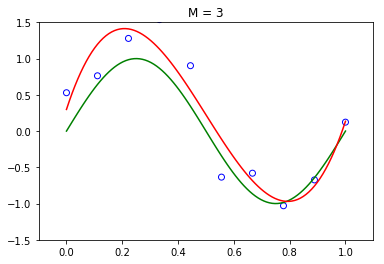

In [14]:
plt.title("M = {0}".format(M))
plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
plt.plot(np.linspace(0, 1, 100), y(np.linspace(0, 1, 100)), color = "r")
plt.scatter(x, t, facecolors = 'none', edgecolors = "b")
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.show()

このあとの検証のために、パラメータ調節を関数化しておく。

In [15]:
def fit(x, t, M):
    N = x.size
    
    A_index_i = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) % (M + 1)
    A_index_j = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) // (M + 1)
    A_index_ij = A_index_i + A_index_j
    A = np.sum(np.power(x.reshape([N, 1, 1]), np.tile(A_index_ij, [N, 1, 1])), axis = 0)
    
    T_index_i = np.arange(0, (M + 1))
    T = np.sum(np.power(x.reshape([N, 1]), np.tile(T_index_i, [N, 1])) * t.reshape([N, 1]), axis = 0)
    
    w = np.linalg.solve(A, T)
    y = np.frompyfunc(lambda x: np.sum(w * np.power(x, np.arange(0, M + 1))), 1, 1)
    
    return y, w

同様に、モデルの描画も関数化しておく。

In [16]:
def plot_curve(x, t, y, M):
    plt.title("M = {0}".format(M))
    plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
    plt.plot(np.linspace(0, 1, 100), y(np.linspace(0, 1, 100)), color = "r")
    plt.scatter(x, t, facecolors = 'none', edgecolors = "b")
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1.5, 1.5)
    plt.show()

### 機械学習の課題

データや問題に対してモデルが複雑すぎると、**過学習 (over-fitting)** と呼ばれる現象が起こる。<br>
過学習が起こると、訓練集合の誤差は小さくなるがテスト集合に対する誤差は大きくなり、汎化性能が低下する。<br>
そのため適切な複雑さのモデルを選ぶ必要があるが、この作業を**モデル選択 (model selection)** と呼ぶ。

$N = 10$ に固定し、$M$ の値を $M = 3$ と $M = 9$ に設定したときのモデルを比較する。<br>
次のようなことがわかる。

* $M = 3$ のときは元の正弦波に近い形をしているものの、$M = 9$ のときは元の正弦波から大きく外れた形をしている。
* $\textbf{w}$ が $M = 9$ のときは $M = 3$ よりもずっと大きな値になっている。

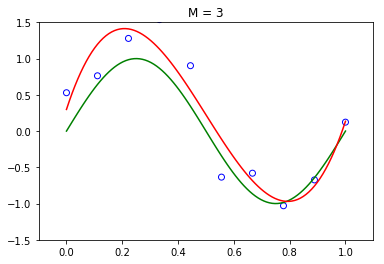

In [17]:
y, w = fit(x, t, 3)
plot_curve(x, t, y, 3)

In [18]:
w

array([  0.29868964,  11.76189703, -35.71669431,  23.79151378])

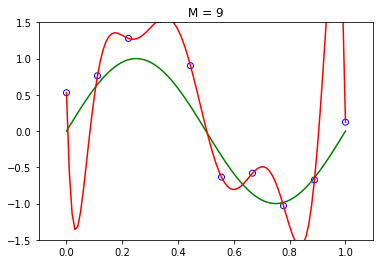

In [19]:
y, w = fit(x, t, 9)
plot_curve(x, t, y, 9)

In [20]:
w

array([ 5.29216247e-01, -1.38569243e+02,  3.33197418e+03, -3.10968897e+04,
        1.52663147e+05, -4.34903828e+05,  7.41290020e+05, -7.43998805e+05,
        4.04995223e+05, -9.21426774e+04])

今度は、$M = 9$ に固定し、$N$ を $N = 10$ と $N = 100$ に設定したときのモデルを比較する。<br>
次のようなことがわかる。

* $N = 10$ のときは元の正弦波から大きく外れた形をしているが、$N = 100$ のときは元の正弦波に近い形になっている。
* $\textbf{w}$ は $N$ にかかわらず非常に大きな値になっている。

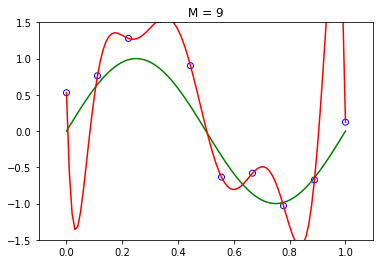

In [21]:
y, w = fit(x, t, 9)
plot_curve(x, t, y, 9)

In [22]:
w

array([ 5.29216247e-01, -1.38569243e+02,  3.33197418e+03, -3.10968897e+04,
        1.52663147e+05, -4.34903828e+05,  7.41290020e+05, -7.43998805e+05,
        4.04995223e+05, -9.21426774e+04])

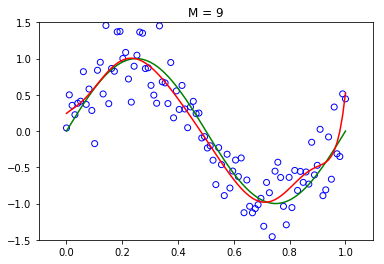

In [23]:
y, w = fit(x_test, t_test, 9)
plot_curve(x_test, t_test, y, 9)

In [24]:
w

array([ 2.44351950e-01,  3.22012400e+00, -3.17439518e+01,  7.37221830e+02,
       -5.45979876e+03,  1.90117216e+04, -3.66257333e+04,  4.01697165e+04,
       -2.34694905e+04,  5.66516602e+03])

### 過学習の抑制方法｜訓練集合とテスト集合のそれぞれに対する誤差を求め過学習を評価する

適切なモデルの複雑さを決めるためには、モデルの汎化性能を定量的に評価する必要がある。<br>
そのためには訓練集合とテスト集合のそれぞれに対して誤差を求め、誤差の乖離を確認すればよい。<br>
誤差には、次の**平均二乗平方根誤差 (root-mean-square error, RMS error)** を使うと便利である。

$$
E_{\text{RMS}} = \sqrt{\frac{2 E(\textbf{w}^\star)}{N}}
$$

ここで、$\textbf{w}^\star$ は調節済みパラメータを表す。<br>
二乗和誤差の $\textbf{w}$ を $\textbf{w}^\star$ で固定し $\textbf{x}$ と $\textbf{t}$ の関数とみなせば、$\textbf{x}$ や $\textbf{t}$ を差し替えることで任意の集合に対する平均二乗平方根誤差を求めることができる。

平均二乗平方根誤差は次のような性質を持つ。

* $N$ で割ることで、サイズの異なる集合を比較することができる
* 平方根を取ることで、目標変数と同じ単位になる

試しに、先ほど作成した $M = 9$ のモデルの誤差を求める。<br>
まず平均二乗平方根誤差を求める関数を定義する。

In [25]:
calc_rmse = lambda t_true, t_pred: np.sqrt(np.sum((t_true - t_pred)**2) / t_true.size)

訓練集合に対する誤差を求める。

In [26]:
y, w = fit(x, t, 9)

In [27]:
calc_rmse(t, y(x))

2.1386283521602244e-05

テスト集合に対する誤差を求める。

In [28]:
calc_rmse(t_test, y(x_test))

0.9531279671541851

訓練集合に対する誤差は非常に小さいのに対し、テスト集合に対する誤差は大きく、過学習が起こっていることがわかる。

### 過学習の抑制方法｜モデルの複雑さを直接抑える

過学習を抑制する方法として、モデルの複雑さを直接抑えることが考えられる。<br>
多項式においては、$M$ を小さくすることがそれにあたる。

過学習の少ない $M$ を選ぶために、いろいろな $M$ に対して誤差を求める。<br>
その結果、$M = 3$ あたりが誤差の乖離が少なくテスト集合に対する誤差も小さいので良さそうだとわかった。

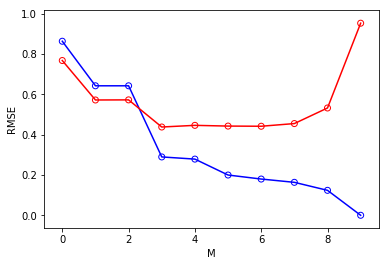

In [29]:
Ms = np.arange(0, 10)
ys, ws = np.frompyfunc(lambda M: fit(x, t, M), 1, 2)(Ms)
rmses_train = np.frompyfunc(lambda y: calc_rmse(t, y(x)), 1, 1)(ys)
rmses_test = np.frompyfunc(lambda y: calc_rmse(t_test, y(x_test)), 1, 1)(ys)

plt.plot(Ms, rmses_train, color = "b")
plt.scatter(Ms, rmses_train, facecolors = 'none', edgecolors = "b")
plt.plot(Ms, rmses_test, color = "r")
plt.scatter(Ms, rmses_test, facecolors = 'none', edgecolors = "r")
plt.xlabel("M")
plt.ylabel("RMSE")
plt.show()

モデルを複雑にすると過学習が進む様子を観察するために、いろいろな $M$ のモデルを描画する。

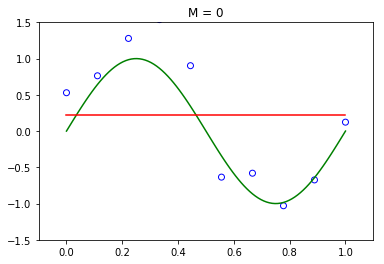

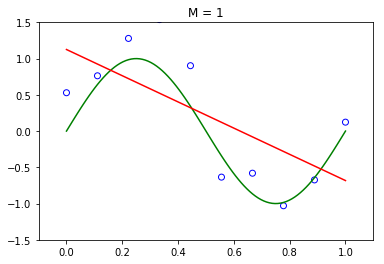

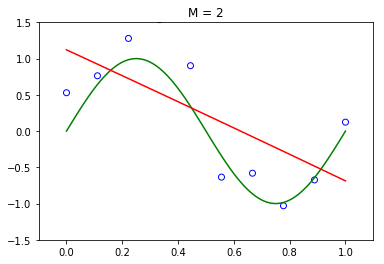

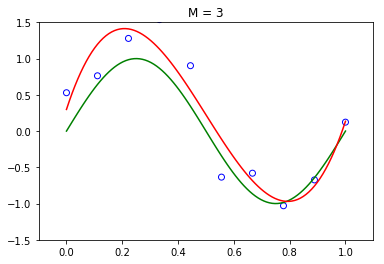

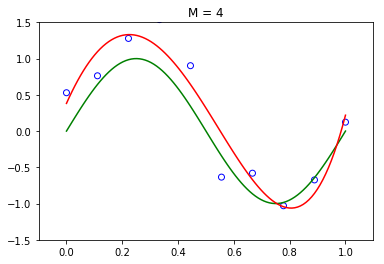

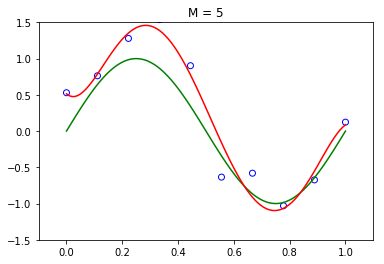

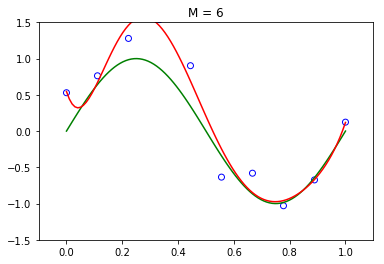

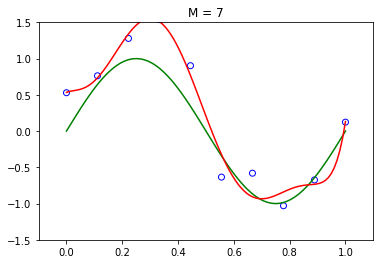

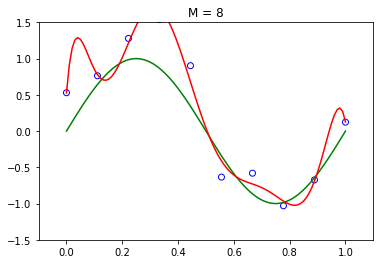

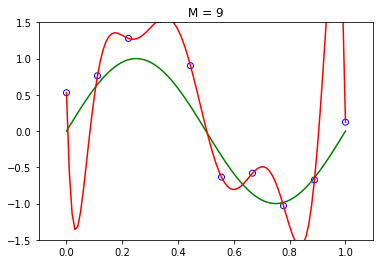

In [30]:
Ms = np.arange(0, 10)
ys, ws = np.frompyfunc(lambda M: fit(x, t, M), 1, 2)(Ms)

for M, y in zip(Ms, ys):
    plot_curve(x, t, y, M)

### 過学習の抑制方法｜正則化して複雑なモデルの実質的な複雑さを抑える

モデルの複雑さを直接抑える方法の他に、複雑なモデルの実質的な複雑さを抑える方法として**正則化**がよく使われる。<br>
正則化では、誤差関数に罰金項を付加することで係数が大きくなることを防ぎ、過学習を抑える。

正則化のように、係数を小さく抑えることで過学習を防ぐテクニックを**縮小推定 (shrinkage)** と呼ぶ。

罰金項の最も単純な例は $\|\textbf{w}\|$ であり、罰金項を加えた誤差関数は次のように表せる。<br>
$\lambda$ は二乗誤差と正則化項の相対的な重要度を調節する役割を果たす係数である。

$$
\tilde{E} \left(\textbf{w} \right) = \frac{1}{2} \sum^{N}_{n = 1}{\left \{y \left(x_n, \textbf{w} \right) - t_n \right\}}^2 + \frac{\lambda}{2}{\|\textbf{w}\|}^2
$$

$\|\textbf{w}\|$ を用いた回帰を**リッジ回帰 (ridge regression)** と呼ぶ。<br>
ニューラルネットワークの文脈では**荷重減衰 (weight decay)** として知られる。

$\tilde{E}\left(\textbf{w} \right)$ は下に凸な2次関数であり、極値が最小値になるから、最小値を求めるためには $\frac{\partial}{\partial w_i} \tilde{E}\left(\textbf{w} \right) = 0$ を解けばよい。

(以下、演習1.2の解答) $E\left(\textbf{w}\right)$ を $w_i$ で偏微分すると、

$$
\begin{align}
\frac{\partial}{\partial w_i} \tilde{E}\left(\textbf{w}\right)
&= \frac{1}{2} \sum^{N}_{n = 1}{\left\{2 \left(\sum^{M}_{j = 0}{w_j \left(x_n \right)^j} - t_n \right) \left(x_n \right)^i \right\}} + \frac{\lambda}{2}\left(2 w_i \right) \\
&= \sum^{N}_{n = 1}{\left(\left(x_n \right)^i \sum^{M}_{j = 0}{w_j \left(x_n \right)^j} \right)} + \lambda w_i - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n} \\
&= \sum^{M}_{j = 0}{\left(w_j \sum^{N}_{n = 1}{\left(x_n \right)^{i + j}} \right)} + \lambda w_i - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n}
\end{align}
$$

となる。ここで、クロネッカーのデルタ $\delta_{ij}$ を用いると、

$$
\begin{align}
\frac{\partial}{\partial w_i} \tilde{E}\left(\textbf{w}\right)
&= \sum^{M}_{j = 0}{\left(w_j \sum^{N}_{n = 1}{\left(x_n \right)^{i + j}} \right)} + \sum^{M}_{j = 0}{\delta_{ij} \lambda w_j} - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n} \\
&= \sum^{M}_{j = 0}{\left\{w_j \left(\sum^{N}_{n = 1}{\left(x_n \right)^{i + j}} + \delta_{ij} \lambda \right) \right\}} - \sum^{N}_{n = 1}{\left(x_n \right)^i t_n}
\end{align}
$$

と変形できる。$\tilde{A}_{ij} = \sum^{N}_{n = 1}{\left(x_n \right)^{i + j}} + \delta_{ij} \lambda$、$T_i = \sum^{N}_{n = 1}{\left(x_n \right)^i t_n}$ と置くと、

$$
\frac{\partial}{\partial w_i} \tilde{E}\left(\textbf{w} \right) = \sum^{M}_{j = 0}{\tilde{A}_{ij} w_j} - T_i
$$

と表せる。

$\frac{\partial}{\partial w_i} \tilde{E}\left(\textbf{w} \right) = 0$ を解くと、

$$
\sum^{M}_{j=0}{\tilde{A}_{ij} w_j} = T_i
$$

となる。この連立方程式を行列で表現すると、

$$
\begin{bmatrix}
\tilde{A}_{00} & \tilde{A}_{01} & \ldots & \tilde{A}_{0j} & \ldots & \tilde{A}_{0M} \\
\tilde{A}_{10} & \tilde{A}_{11} & \ldots & \tilde{A}_{1j} & \ldots & \tilde{A}_{1M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\tilde{A}_{i0} & \tilde{A}_{i1} & \ldots & \tilde{A}_{ij} & \ldots & \tilde{A}_{iM} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\tilde{A}_{M0} & \tilde{A}_{M1} & \ldots & \tilde{A}_{Mj} & \ldots & \tilde{A}_{MM}
\end{bmatrix}
\textbf{w}=
\begin{bmatrix}
T_0 \\
T_1 \\
\vdots \\
T_i \\
\vdots \\
T_M
\end{bmatrix}
$$

と表せる。ここで、

$$
\begin{bmatrix}
\tilde{A}_{00} & \tilde{A}_{01} & \ldots & \tilde{A}_{0j} & \ldots & \tilde{A}_{0M} \\
\tilde{A}_{10} & \tilde{A}_{11} & \ldots & \tilde{A}_{1j} & \ldots & \tilde{A}_{1M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\tilde{A}_{i0} & \tilde{A}_{i1} & \ldots & \tilde{A}_{ij} & \ldots & \tilde{A}_{iM} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
\tilde{A}_{M0} & \tilde{A}_{M1} & \ldots & \tilde{A}_{Mj} & \ldots & \tilde{A}_{MM}
\end{bmatrix}
=
\begin{bmatrix}
A_{00} & A_{01} & \ldots & A_{0j} & \ldots & A_{0M} \\
A_{10} & A_{11} & \ldots & A_{1j} & \ldots & A_{1M} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
A_{i0} & A_{i1} & \ldots & A_{ij} & \ldots & A_{iM} \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
A_{M0} & A_{M1} & \ldots & A_{Mj} & \ldots & A_{MM}
\end{bmatrix}
+
\begin{bmatrix}
\lambda & 0 & \ldots & 0 & \ldots & 0 \\
0 & \lambda & \ldots & 0 & \ldots & 0 \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
0 & 0 & \ldots & \lambda & \ldots & 0 \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
0 & 0 & \ldots & 0 & \ldots & \lambda
\end{bmatrix}
=
\textbf{A} + \lambda \textbf{I}
$$

とだから、$\textbf{T} = \left\{T_i \right\}$ と置いて $\textbf{w}$ について解くと、

$$
\textbf{w} = \left(\textbf{A} + \lambda \textbf{I}\right)^{-1} \textbf{T}
$$

を得る。

以上の議論を踏まえ、正則化版のパラメータ調整を実装する。

In [31]:
def fit(x, t, M, l):
    N = x.size
    
    A_index_i = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) % (M + 1)
    A_index_j = np.arange(0, (M + 1) * (M + 1)).reshape([M + 1, M + 1]) // (M + 1)
    A_index_ij = A_index_i + A_index_j
    A = np.sum(np.power(x.reshape([N, 1, 1]), np.tile(A_index_ij, [N, 1, 1])), axis = 0) + np.identity(M + 1) * l
    
    T_index_i = np.arange(0, (M + 1))
    T = np.sum(np.power(x.reshape([N, 1]), np.tile(T_index_i, [N, 1])) * t.reshape([N, 1]), axis = 0)
    
    w = np.linalg.solve(A, T)
    y = np.frompyfunc(lambda x: np.sum(w * np.power(x, np.arange(0, M + 1))), 1, 1)
    
    return y, w

合わせて、モデルを描画する関数も実装する。

In [32]:
def plot_curve(x, t, y, l):
    plt.title("log10(lambda) = {0}".format(l))
    plt.plot(np.linspace(0, 1, 100), np.sin(2 * np.pi * np.linspace(0, 1, 100)), color = "g")
    plt.plot(np.linspace(0, 1, 100), y(np.linspace(0, 1, 100)), color = "r")
    plt.scatter(x, t, facecolors = 'none', edgecolors = "b")
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1.5, 1.5)
    plt.show()

過学習の少ない $\lambda$ を選ぶために、いろいろな $\lambda$ に対して誤差を求める。<br>
その結果、$\lambda = 10^{-3}$ あたりが誤差の乖離が少なくテスト集合に対する誤差も小さいので良さそうだとわかった。

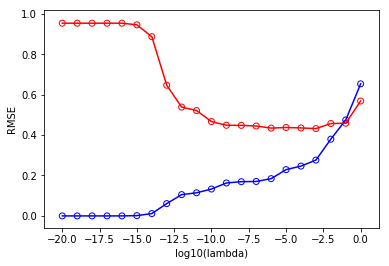

In [33]:
M = 9
ls = np.arange(-20, 1)
ys, ws = np.frompyfunc(lambda l: fit(x, t, M, 10**l), 1, 2)(ls)
rmses_train = np.frompyfunc(lambda y: calc_rmse(t, y(x)), 1, 1)(ys)
rmses_test = np.frompyfunc(lambda y: calc_rmse(t_test, y(x_test)), 1, 1)(ys)

plt.plot(ls, rmses_train, color = "b")
plt.scatter(ls, rmses_train, facecolors = 'none', edgecolors = "b")
plt.plot(ls, rmses_test, color = "r")
plt.scatter(ls, rmses_test, facecolors = 'none', edgecolors = "r")
plt.xlabel("log10(lambda)")
plt.ylabel("RMSE")
plt.show()

$\lambda$ を大きくすると過学習が抑制されていく様子を観察するために、いろいろな $\lambda$ のモデルを描画する。

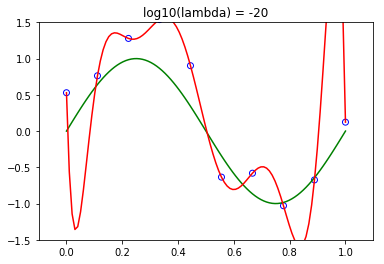

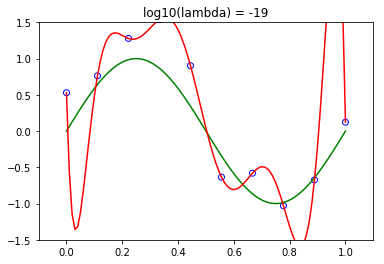

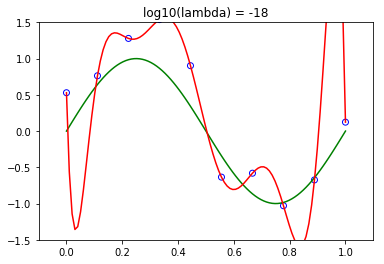

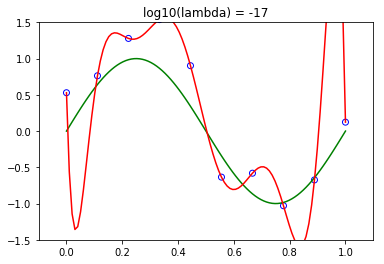

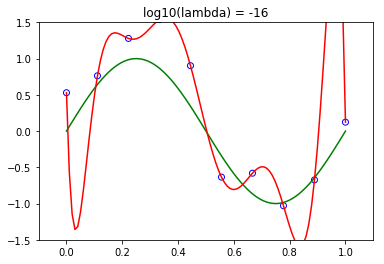

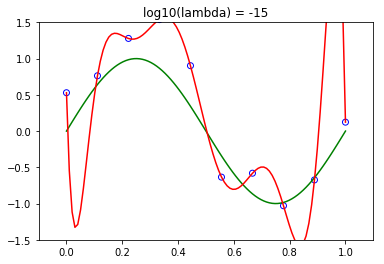

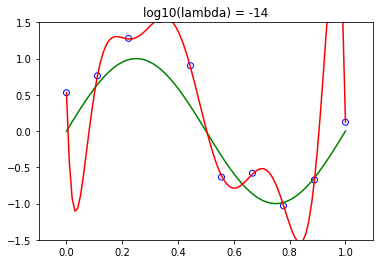

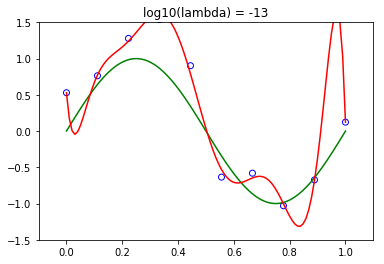

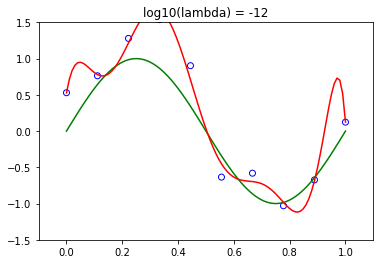

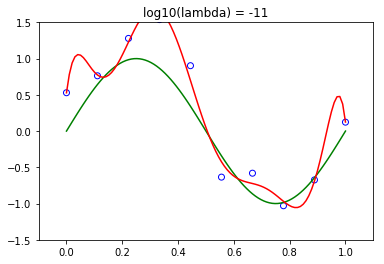

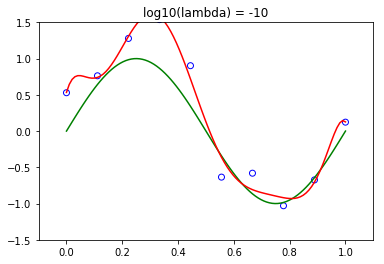

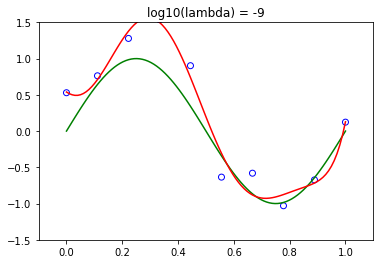

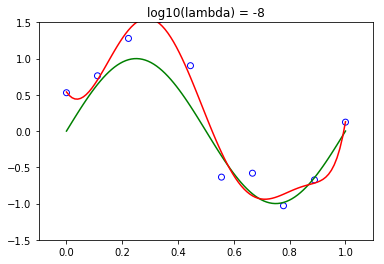

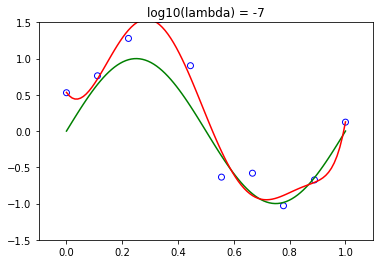

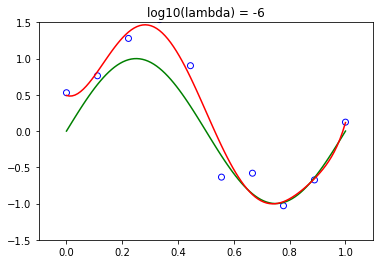

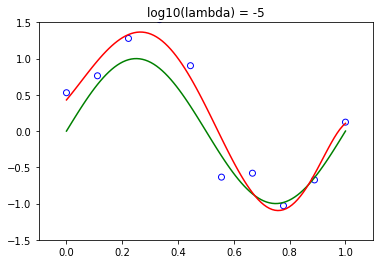

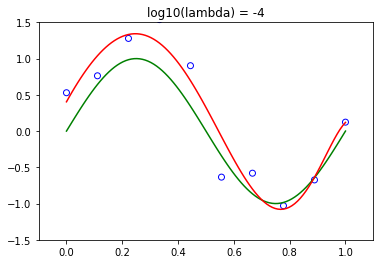

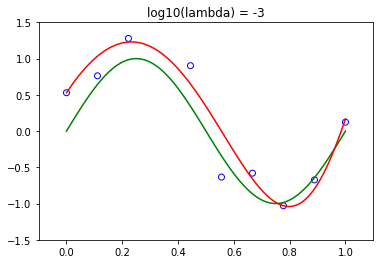

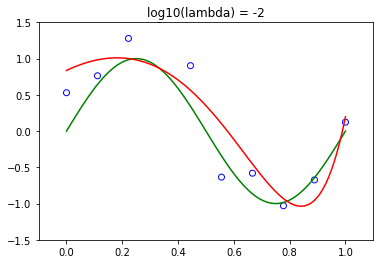

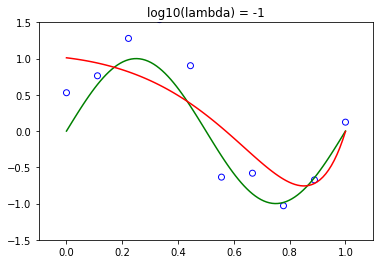

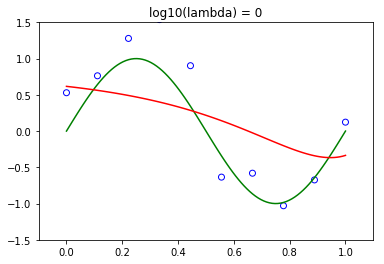

In [34]:
M = 9
ls = np.arange(-20, 1)
ys, ws = np.frompyfunc(lambda l: fit(x, t, M, 10**l), 1, 2)(ls)

for l, y in zip(ls, ys):
    plot_curve(x, t, y, l)

### 本節で棚上げしたこと

* 線形モデルは重要な性質を持つ (3章と4章で説明)
* 二乗和誤差を最小化することでモデルのパラメータを調節するアプローチは最尤推定の特別な場合である (1.2.5節で説明)
* 過学習は最尤推定が持つ性質である (1.2.5節で説明)
* ベイズモデルを使えば過学習は回避できる (3.4節で説明)
* モデルの複雑さを決めるためには確認用集合が必要だが、それを訓練集合を無駄にせず実現する洗練されたアプローチがある (1.3節で説明)

---

## 疑問点

* $\textbf{w}$ を小さく抑えることで過学習を抑えることができる理屈がわからない。